In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import astropy.units as u
from datetime import datetime
from astropy.coordinates import SkyCoord
import pickle
import json
import sys
import os
import pandas as pd
from sys import getsizeof
pd.set_option('display.max_columns', None)

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/systematics/scripts"))
import auxiliar as aux
green = "#009736"
red = "#EE2A35"

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# dirs
objects_dir = "/fefs/aswg/workspace/juan.jimenez/systematics/objects"

# use from coordinates (use astropy units) or from name
target_ra  = None
target_dec = None
target_name = "Crab"

# select he number of off regions
n_off_regions = 3

# energy edges for spectrum
e_min = 80 * u.GeV
e_max = 20 * u.TeV

# energy edges for lightcurve
e_lc_min = 100 * u.GeV
e_lc_max = 20 * u.TeV

# intensity integration limits
intensity_integration_lims = [100, 160] #ph

In [2]:
%%time
###################
# reading objects
###################
# light curve data
with open(f'{objects_dir}/dict_LC.pkl', 'rb') as f:
    dict_LC = pickle.load(f)

dict_LC_2 = {}
for i, run in enumerate(np.array(dict_LC["run_number"]).astype(int)):
    tmp_dict = {
        "flux" : dict_LC["flux"][i], 
        "e_flux" : dict_LC["e_flux"][i], 
        "timestamp" : dict_LC["timestamp"][i], 
        "duration" : dict_LC["duration"][i], 
        "zd" : dict_LC["zd"][i],
        "az" : dict_LC["az"][i]
    }
    dict_LC_2[run] = tmp_dict
    
# l2 to dl3 information
with open(f"{objects_dir}/total_dict_runs.json", "r") as json_file:
    dict_dl2todl3 = json.load(json_file)
    
# load dl2 desired data
with open('objects/dict_dl2.pkl', 'rb') as f:
    dict_dl2 = pickle.load(f)

CPU times: user 1.47 s, sys: 29.7 s, total: 31.2 s
Wall time: 4min 10s


In [3]:
dict_runs = {}

for run in dict_dl2.keys():
    
    tmp_dict = {
        "flux" : dict_LC_2[run]["flux"].value,
        "e_flux": dict_LC_2[run]["e_flux"].value,
        "zd" : dict_LC_2[run]["zd"].value,
        "az" : dict_LC_2[run]["az"].value,
        "timestamp" : dict_LC_2[run]["timestamp"],
        "effective_time" : dict_dl2[run]["effective_time"],
    }
    
    dict_runs[run] = tmp_dict

### Bulk of data, without adjustments

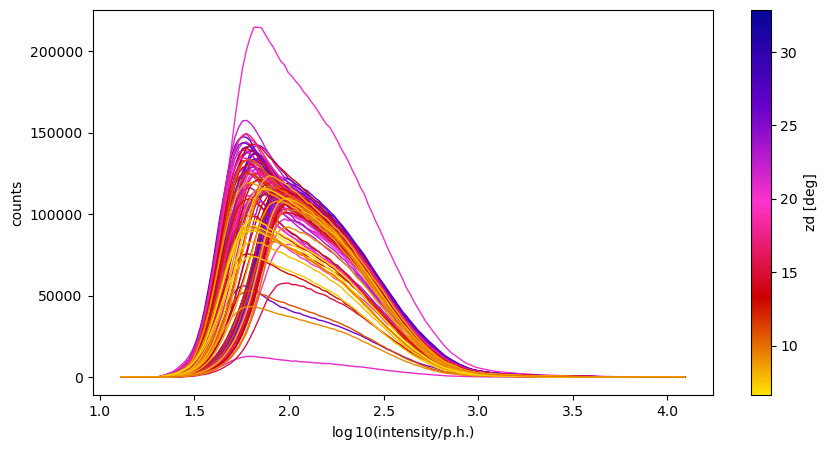

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))

bins = np.linspace(1.1, 4.1, 150)

for run in [_ for _ in dict_runs.keys()][:]:  
    
    # getting the color of each run
    X = np.abs(dict_runs[run]["zd"] - max(dict_LC["zd"]).value) / max(dict_LC["zd"]).value
    color = aux.color_cr(X, COLORS=list(reversed(aux.predC)))

    counts, Iedges = np.histogram(np.log10(dict_dl2[run]["intensity"]), bins)
    Icenters = (Iedges[1:] + Iedges[:-1]) / 2
    ax.plot(Icenters, counts, color=color, lw=1) # drawstyle='steps-mid'

#######################################
# creating a colorbar
cmap=aux.create_cmap(list(reversed(aux.predC)))
norm = mpl.colors.Normalize(vmin=min(dict_LC["zd"]).value, vmax=max(dict_LC["zd"]).value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="zd [deg]")
#######################################

ax.set_xlabel("$\log10($intensity/p.h.$)$")
ax.set_ylabel("counts")
plt.show()

### Time correction

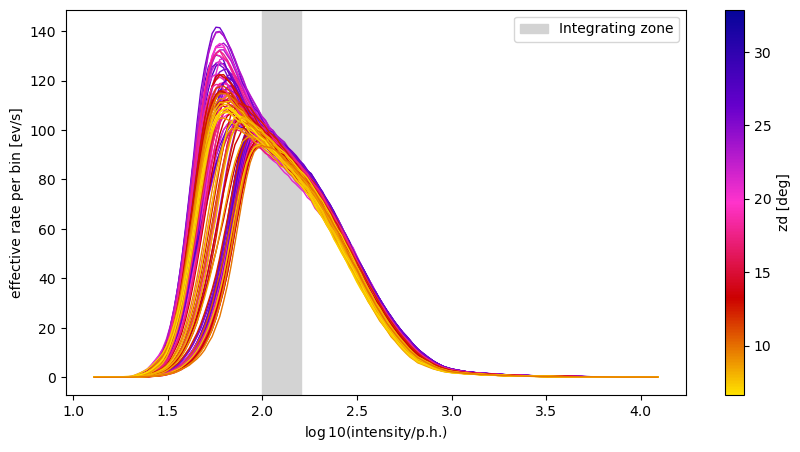

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

bins = np.linspace(1.1, 4.1, 150) 

for run in [_ for _ in dict_dl2.keys()][:]:  
    
    # getting the color of each run
    X = np.abs(dict_runs[run]["zd"] - max(dict_LC["zd"]).value) / max(dict_LC["zd"]).value
    color = aux.color_cr(X, COLORS=list(reversed(aux.predC)))

    counts, Iedges = np.histogram(np.log10(dict_dl2[run]["intensity"]), bins)
    Icenters = (Iedges[1:] + Iedges[:-1]) / 2
    counts   = counts / dict_dl2[run]["effective_time"]
    
    integral = 0
    for i, b in enumerate(bins[:-1]):
        if bins[i] > np.log10(intensity_integration_lims[0]) and bins[i+1] < np.log10(intensity_integration_lims[1]):
            integral = integral + counts[i]
    
    dict_runs[run]["p_rate"] = integral
    
    ax.plot(Icenters, counts, color=color, lw=1)

ax.axvspan(np.log10(intensity_integration_lims[0]), np.log10(intensity_integration_lims[1]), color="lightgray", label="Integrating zone")

#######################################
# creating a colorbar
cmap=aux.create_cmap(list(reversed(aux.predC)))
norm = mpl.colors.Normalize(vmin=min(dict_LC["zd"]).value, vmax=max(dict_LC["zd"]).value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="zd [deg]")
#######################################

ax.legend()
ax.set_xlabel("$\log10($intensity/p.h.$)$")
ax.set_ylabel("effective rate per bin [ev/s]")
plt.show()

In [13]:
# extracting values as arrays
p_rate = []
flux   = []
e_flux = []
zd, az = [], []

for run in dict_runs.keys():
    flux.append(dict_runs[run]["flux"])
    e_flux.append(dict_runs[run]["e_flux"])
    zd.append(dict_runs[run]["zd"])
    az.append(dict_runs[run]["az"])
    p_rate.append(dict_runs[run]["p_rate"])

flux   = np.array(flux)
e_flux = np.array(e_flux)
p_rate = np.array(p_rate)
zd = np.array(zd)
az = np.array(az)

### Some distributions

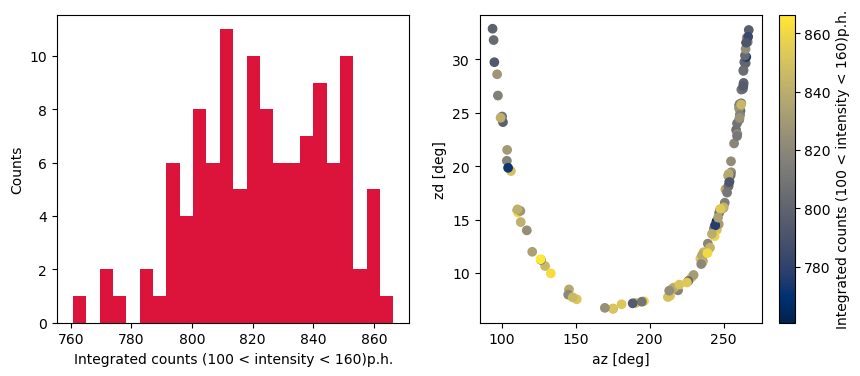

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

bins = np.linspace(np.min(p_rate), np.max(p_rate), 25)
ax1.hist(p_rate, bins, color="crimson")

sc = ax2.scatter(az, zd, c=p_rate, cmap="cividis")
fig.colorbar(sc, label=f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")


ax1.set_ylabel("Counts")
ax1.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax2.set_xlabel("az [deg]")
ax2.set_ylabel("zd [deg]")
plt.show()

### Linearly fitting the zd to the counts

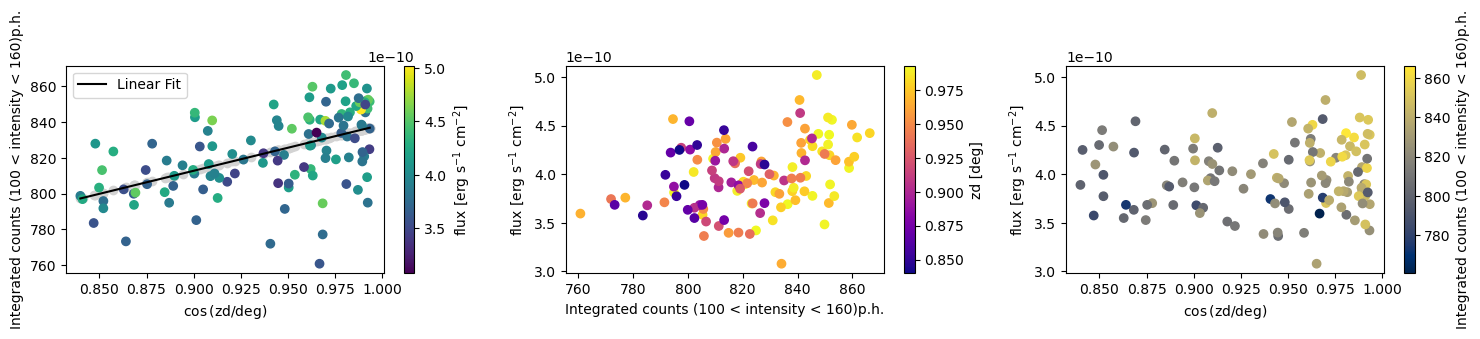

In [15]:
# Perform linear fits
fitF_zd_p = np.poly1d(np.polyfit(np.cos(np.deg2rad(zd)), p_rate, 1))    
    
############################################
# plot the figures
############################################
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

# scatter plots

sc1 = ax1.scatter(np.cos(np.deg2rad(zd)), p_rate, c=flux,                   cmap="viridis")
sc2 = ax2.scatter(p_rate,                 flux,   c=np.cos(np.deg2rad(zd)), cmap="plasma")
sc3 = ax3.scatter(np.cos(np.deg2rad(zd)), flux,   c=p_rate,                 cmap="cividis")

fig.colorbar(sc1, ax=ax1, label="flux [erg s${}^{-1}$ cm${}^{-2}$]")
fig.colorbar(sc2, ax=ax2, label="zd [deg]")
fig.colorbar(sc3, ax=ax3, label=f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")


####################
# plot lines
####################
zd_array = np.linspace(min(np.cos(np.deg2rad(zd))), max(np.cos(np.deg2rad(zd))), 200)

ax1.plot(zd_array, fitF_zd_p(zd_array), '-k', label="Linear Fit")

#displace the points
ax1.scatter(np.cos(np.deg2rad(zd)), fitF_zd_p(np.cos(np.deg2rad(zd))), color="lightgray", zorder=-10)

ax1.legend()
ax1.set_ylabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax1.set_xlabel("$\cos$(zd/deg)")
ax2.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
ax2.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax3.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
ax3.set_xlabel(f"$\cos$(zd/deg)")

fig.tight_layout()
plt.show()

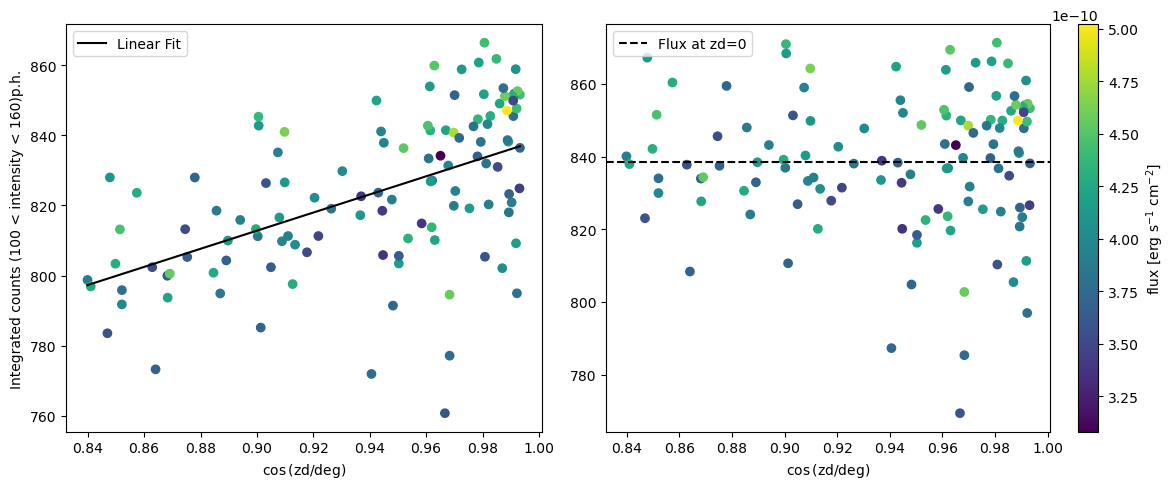

In [36]:
zd_0_p_rate = []
for run in dict_runs.keys():
    
    _zd_0_p_rate = dict_runs[run]["p_rate"] - fitF_zd_p(np.cos(np.deg2rad(dict_runs[run]["zd"]))) + fitF_zd_p(1)
    
    dict_runs[run]["zd_0_p_rate"] = _zd_0_p_rate
    zd_0_p_rate.append(_zd_0_p_rate)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1.2, 1.4]})

# scatter plots
sc1 = ax1.scatter(np.cos(np.deg2rad(zd)), p_rate,      c=flux, cmap="viridis")
sc2 = ax2.scatter(np.cos(np.deg2rad(zd)), zd_0_p_rate, c=flux, cmap="viridis")

fig.colorbar(sc2, ax=ax2, label="flux [erg s${}^{-1}$ cm${}^{-2}$]")


####################
# plot lines
####################
zd_array = np.linspace(min(np.cos(np.deg2rad(zd))), max(np.cos(np.deg2rad(zd))), 200)

ax1.plot(zd_array, fitF_zd_p(zd_array), '-k', label="Linear Fit")
ax2.axhline(np.mean(zd_0_p_rate), color="k", ls="--", label="Flux at zd=0")


ax1.legend()
ax2.legend()
ax1.set_ylabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax1.set_xlabel("$\cos$(zd/deg)")
ax2.set_xlabel("$\cos$(zd/deg)")

fig.tight_layout()
plt.show()

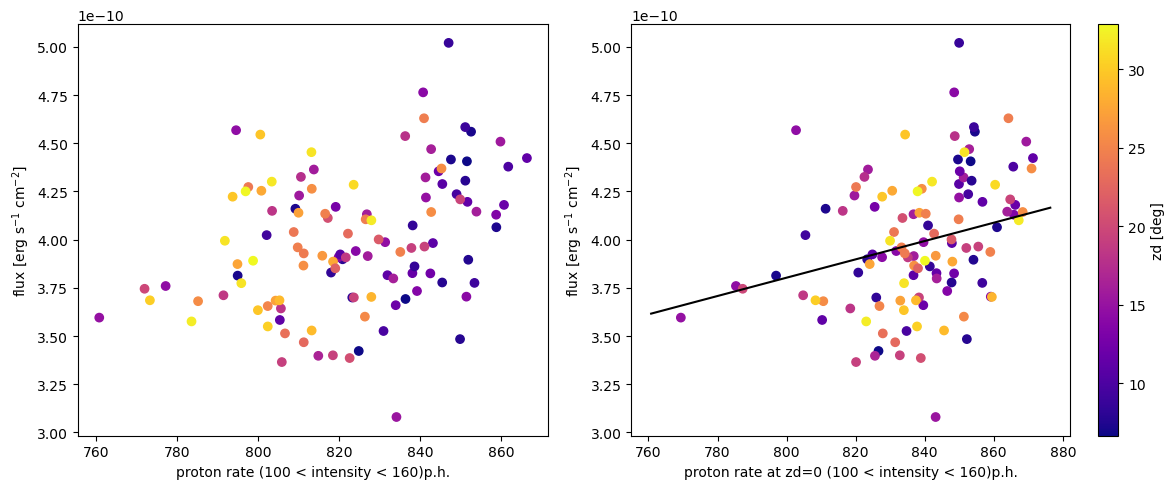

In [53]:
slope = np.dot(zd_0_p_rate, flux) / np.dot(zd_0_p_rate, zd_0_p_rate)

def linear_regression(x_value):
    return slope * x_value

for run in dict_runs.keys():
    _factor = linear_regression(dict_runs[run]["zd_0_p_rate"]) / dict_runs[run]["flux"]
    dict_runs[run]["zd_corr"] = _factor
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1.2, 1.4]})

sc1 = ax1.scatter(p_rate, flux, c=zd, cmap="plasma");
sc2 = ax2.scatter(zd_0_p_rate, flux, c=zd, cmap="plasma");
fig.colorbar(sc2, ax=ax2, label="zd [deg]")

####################
p_array = np.linspace(min(p_rate), max(p_rate)+10, 200)
ax2.plot(p_array, linear_regression(p_array), '-k', label="Linear Fit")

ax1.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
ax2.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")

ax1.set_xlabel(f"proton rate ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax2.set_xlabel(f"proton rate at zd=0 ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")

fig.tight_layout()
plt.show()

### Applying corrections


--------------------------------------------
APPLYING CORRECTIONS --> zd_corr
--------------------------------------------




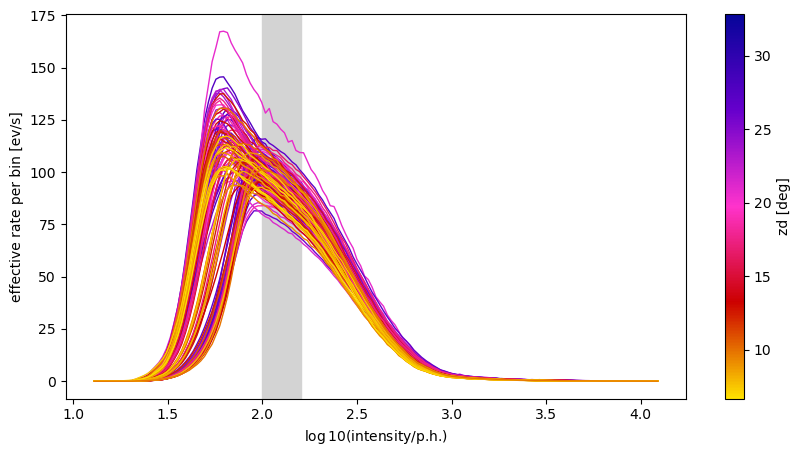

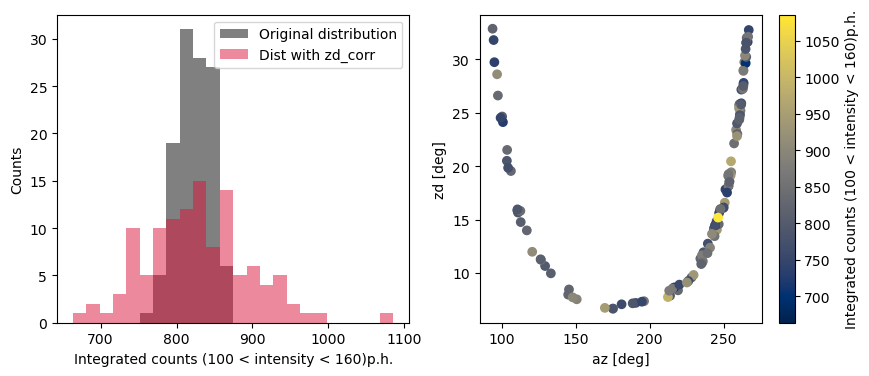

In [54]:
zd_corr_p_rate  = []
zd_corr_flux    = []

corr = "zd_corr"

print("\n--------------------------------------------")
print(f"APPLYING CORRECTIONS --> {corr}")
print("--------------------------------------------\n\n")    

fig, ax = plt.subplots(figsize=(10, 5))

bins = np.linspace(1.1, 4.1, 150) 


for run in [_ for _ in dict_runs.keys()][:]:  

    # getting the color of each run
    X = np.abs(dict_runs[run]["zd"] - max(dict_LC["zd"]).value) / max(dict_LC["zd"]).value
    color = aux.color_cr(X, COLORS=list(reversed(aux.predC)))

    counts, Iedges = np.histogram(np.log10(dict_dl2[run]["intensity"]), bins)
    Icenters = (Iedges[1:] + Iedges[:-1]) / 2
    counts   = counts / dict_runs[run]["effective_time"] * dict_runs[run][corr]

    ax.plot(Icenters, counts, color=color, lw=1)

    integral = 0
    for i, b in enumerate(bins[:-1]):
        if bins[i] > np.log10(intensity_integration_lims[0]) and bins[i+1] < np.log10(intensity_integration_lims[1]):
            integral = integral + counts[i]

    dict_runs[run]["zd_corr_p_rate"] = integral
    dict_runs[run]["zd_corr_flux"]   = dict_runs[run]["flux"] * dict_runs[run][corr]
    zd_corr_p_rate.append(integral)
    zd_corr_flux.append(dict_runs[run]["flux"] * dict_runs[run][corr])

ax.axvspan(np.log10(intensity_integration_lims[0]), np.log10(intensity_integration_lims[1]), color="lightgray", label="Integrating zone")

#######################################
# creating a colorbar
cmap=aux.create_cmap(list(reversed(aux.predC)))
norm = mpl.colors.Normalize(vmin=min(dict_LC["zd"]).value, vmax=max(dict_LC["zd"]).value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="zd [deg]")
#######################################

# ax.legend()
ax.set_xlabel("$\log10($intensity/p.h.$)$")
ax.set_ylabel("effective rate per bin [ev/s]")
# plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

bins = np.linspace(min((min(zd_corr_p_rate), min(p_rate))), max((max(zd_corr_p_rate), max(p_rate))), 25)
ax1.hist(p_rate,         bins, color="gray",  label="Original distribution")
ax1.hist(zd_corr_p_rate, bins, color="crimson", label=f"Dist with {corr}", alpha=0.5)

sc = ax2.scatter(az, zd, c=zd_corr_p_rate, cmap="cividis")
fig.colorbar(sc, label=f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")

ax1.legend()
ax1.set_ylabel("Counts")
ax1.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax2.set_xlabel("az [deg]")
ax2.set_ylabel("zd [deg]")
plt.show()

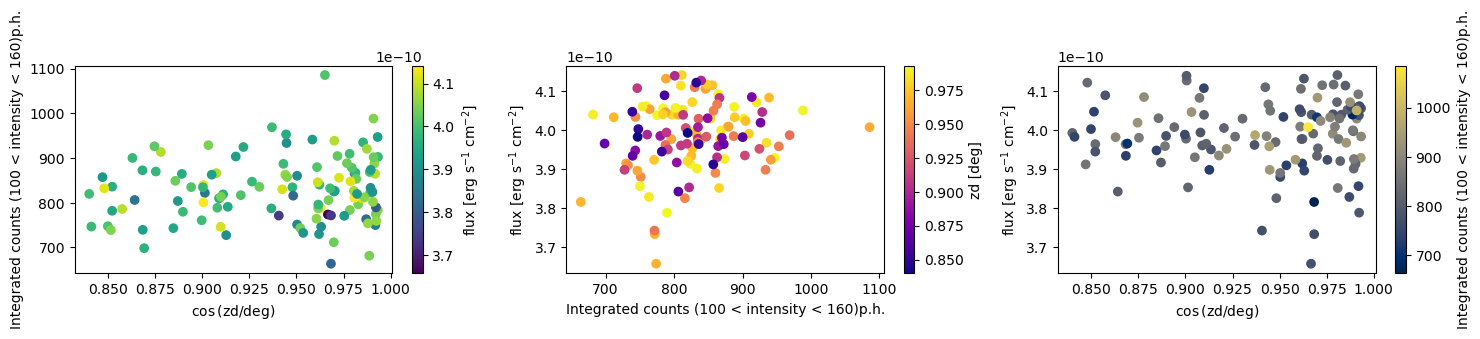

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

# scatter plots
sc1 = ax1.scatter(np.cos(np.deg2rad(zd)), zd_corr_p_rate, c=zd_corr_flux,           cmap="viridis")
sc2 = ax2.scatter(zd_corr_p_rate,         zd_corr_flux,   c=np.cos(np.deg2rad(zd)), cmap="plasma")
sc3 = ax3.scatter(np.cos(np.deg2rad(zd)), zd_corr_flux,   c=zd_corr_p_rate,         cmap="cividis")

fig.colorbar(sc1, ax=ax1, label="flux [erg s${}^{-1}$ cm${}^{-2}$]")
fig.colorbar(sc2, ax=ax2, label="zd [deg]")
fig.colorbar(sc3, ax=ax3, label=f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")


ax1.set_ylabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax1.set_xlabel("$\cos$(zd/deg)")
ax2.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
ax2.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax3.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
ax3.set_xlabel(f"$\cos$(zd/deg)")

fig.tight_layout()
plt.show()

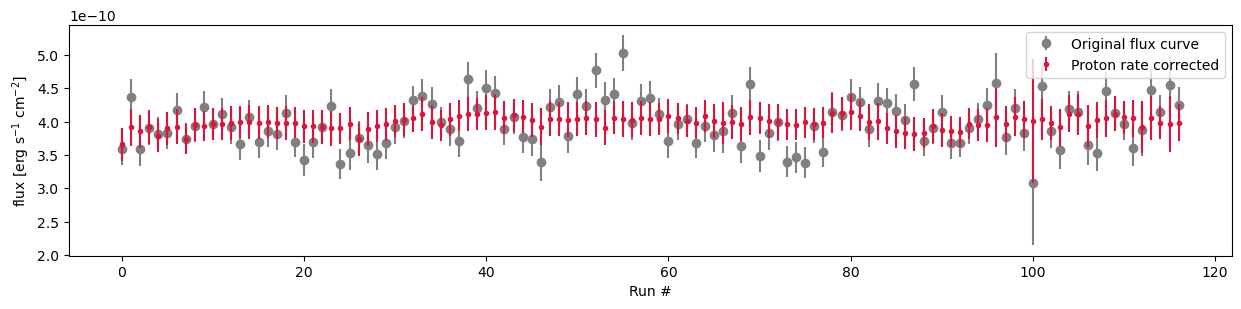

In [59]:
fig, ax = plt.subplots(figsize=(15, 3))

for i, run in enumerate(dict_LC_2.keys()):  

    if i == 0:
        label = "Original flux curve"
        label_zd  = "Proton rate corrected"
    else:   
        label, label_zd = None, None
        
    errors = dict_runs[run]["e_flux"]
    flux_value         = dict_runs[run]["flux"]
    zd_corr_flux_value = dict_runs[run]["zd_corr_flux"]
    
    ax.errorbar(i, flux_value,         yerr=errors, marker="o", ls="", color="gray",  zorder=-10, label=label)
    ax.errorbar(i, zd_corr_flux_value, yerr=errors, marker=".", ls="", color="crimson", label=label_zd)

ax.legend()
ax.set_xlabel(f"Run #")
ax.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
plt.show()

In [21]:
# Perform linear fits
for i, run in enumerate(dict_runs.keys()):
    _factor_p = np.mean(zd_corr_p_rate) / dict_runs[run]["zd_corr_p_rate"]
    
    dict_runs[run]["p_corr"]  = _factor_p


--------------------------------------------
APPLYING CORRECTIONS --> p_corr
--------------------------------------------




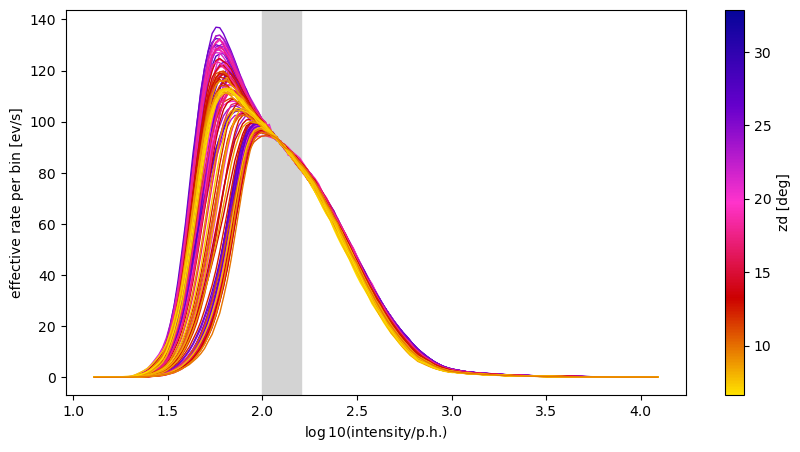

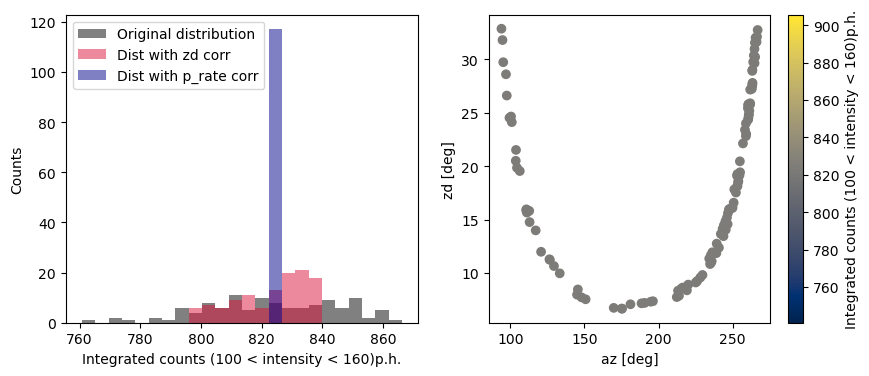

In [22]:
p_corr_p_rate  = []
p_corr_flux    = []

corr = "p_corr"

print("\n--------------------------------------------")
print(f"APPLYING CORRECTIONS --> {corr}")
print("--------------------------------------------\n\n")    

fig, ax = plt.subplots(figsize=(10, 5))

bins = np.linspace(1.1, 4.1, 150) 


for run in [_ for _ in dict_runs.keys()][:]:  

    # getting the color of each run
    X = np.abs(dict_runs[run]["zd"] - max(dict_LC["zd"]).value) / max(dict_LC["zd"]).value
    color = aux.color_cr(X, COLORS=list(reversed(aux.predC)))

    counts, Iedges = np.histogram(np.log10(dict_dl2[run]["intensity"]), bins)
    Icenters = (Iedges[1:] + Iedges[:-1]) / 2
    counts   = counts / dict_runs[run]["effective_time"] * dict_runs[run]["zd_corr"] * dict_runs[run][corr]

    ax.plot(Icenters, counts, color=color, lw=1)

    integral = 0
    for i, b in enumerate(bins[:-1]):
        if bins[i] > np.log10(intensity_integration_lims[0]) and bins[i+1] < np.log10(intensity_integration_lims[1]):
            integral = integral + counts[i]

    dict_runs[run]["p_corr_p_rate"] = integral
    dict_runs[run]["p_corr_flux"]   = dict_runs[run]["zd_corr_flux"] * dict_runs[run][corr]
    p_corr_p_rate.append(integral)
    p_corr_flux.append(dict_runs[run]["zd_corr_flux"] * dict_runs[run][corr])

ax.axvspan(np.log10(intensity_integration_lims[0]), np.log10(intensity_integration_lims[1]), color="lightgray", label="Integrating zone")

#######################################
# creating a colorbar
cmap=aux.create_cmap(list(reversed(aux.predC)))
norm = mpl.colors.Normalize(vmin=min(dict_LC["zd"]).value, vmax=max(dict_LC["zd"]).value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="zd [deg]")
#######################################

# ax.legend()
ax.set_xlabel("$\log10($intensity/p.h.$)$")
ax.set_ylabel("effective rate per bin [ev/s]")
# plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

bins = np.linspace(min((min(zd_corr_p_rate), min(p_corr_p_rate), min(p_rate))), max((max(zd_corr_p_rate), max(p_corr_p_rate), max(p_rate))), 25)
ax1.hist(p_rate,         bins, color="gray",    label="Original distribution")
ax1.hist(zd_corr_p_rate, bins, color="crimson", label=f"Dist with zd corr", alpha=0.5)
ax1.hist(p_corr_p_rate, bins, color="darkblue", label=f"Dist with p_rate corr", alpha=0.5)

sc = ax2.scatter(az, zd, c=p_corr_p_rate, cmap="cividis")
fig.colorbar(sc, label=f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")

ax1.legend()
ax1.set_ylabel("Counts")
ax1.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax2.set_xlabel("az [deg]")
ax2.set_ylabel("zd [deg]")
plt.show()

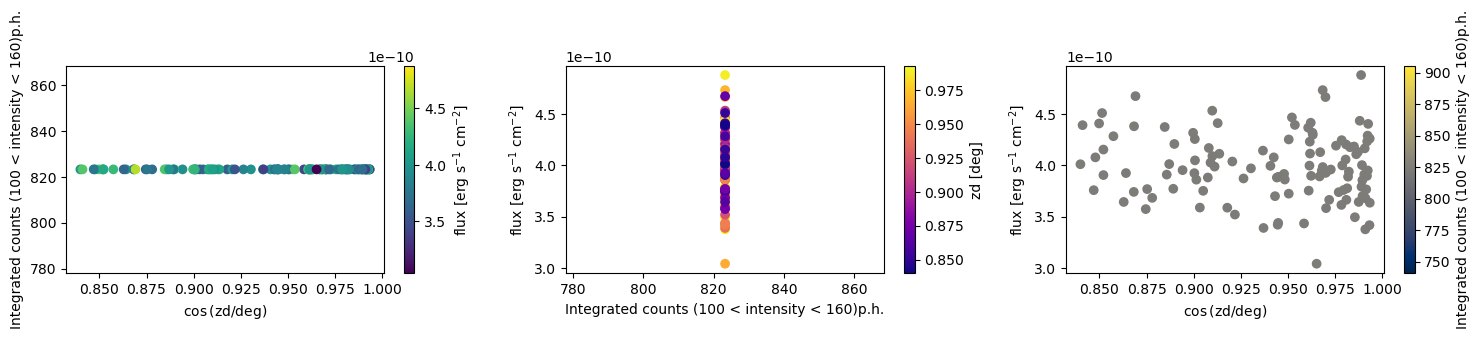

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

# scatter plots
sc1 = ax1.scatter(np.cos(np.deg2rad(zd)), p_corr_p_rate, c=p_corr_flux,            cmap="viridis")
sc2 = ax2.scatter(p_corr_p_rate,          p_corr_flux,   c=np.cos(np.deg2rad(zd)), cmap="plasma")
sc3 = ax3.scatter(np.cos(np.deg2rad(zd)), p_corr_flux,   c=p_corr_p_rate,          cmap="cividis")

fig.colorbar(sc1, ax=ax1, label="flux [erg s${}^{-1}$ cm${}^{-2}$]")
fig.colorbar(sc2, ax=ax2, label="zd [deg]")
fig.colorbar(sc3, ax=ax3, label=f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")


ax1.set_ylabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax1.set_xlabel("$\cos$(zd/deg)")
ax2.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
ax2.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax3.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
ax3.set_xlabel(f"$\cos$(zd/deg)")

fig.tight_layout()
plt.show()

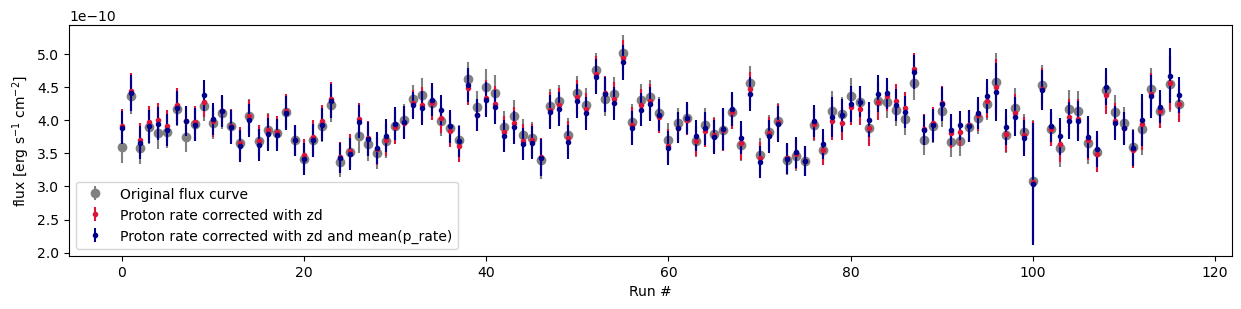

In [24]:
fig, ax = plt.subplots(figsize=(15, 3))

for i, run in enumerate(dict_LC_2.keys()):  

    if i == 0:
        label = "Original flux curve"
        label_zd  = "Proton rate corrected with zd"
        label_p   = "Proton rate corrected with zd and mean(p_rate)"
    else:   
        label, label_zd, label_p = None, None, None
        
    errors = dict_runs[run]["e_flux"]
    flux_value     = dict_runs[run]["flux"]
    zd_corr_flux_value = dict_runs[run]["zd_corr_flux"]
    p_corr_flux_value  = dict_runs[run]["p_corr_flux"]
    
    ax.errorbar(i, flux_value,         yerr=errors, marker="o", ls="", color="gray",    zorder=-10, label=label)
    ax.errorbar(i, zd_corr_flux_value, yerr=errors, marker=".", ls="", color="crimson",  label=label_zd)
    ax.errorbar(i, p_corr_flux_value,  yerr=errors, marker=".", ls="", color="darkblue", label=label_p)

ax.legend()
ax.set_xlabel(f"Run #")
ax.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
plt.show()

Original       = 3.986 ± 0.341   [e-10 erg / (s cm2)]
zd correction  = 3.985 ± 0.320   [e-10 erg / (s cm2)]
mean(p) corr   = 3.985 ± 0.320   [e-10 erg / (s cm2)]


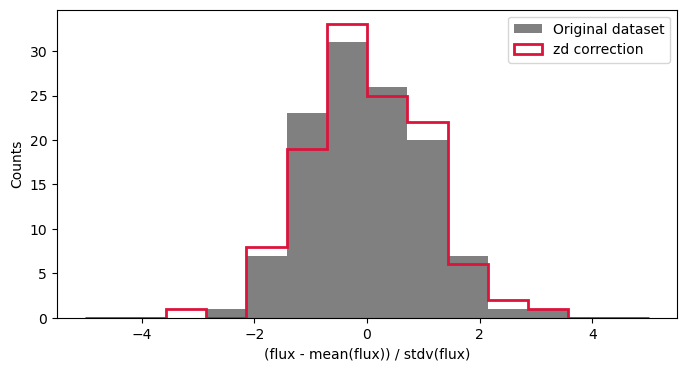

Original dataset  stdv = 1.0
zd correction     stdv = 1.0
mean(p_rate) corr stdv = 0.9999999999999998


In [25]:
chi2         = (flux - np.mean(flux)) / np.std(flux)
zd_corr_chi2 = (zd_corr_flux - np.mean(zd_corr_flux)) / np.std(zd_corr_flux)
p_corr_chi2  = (p_corr_flux - np.mean(p_corr_flux)) / np.std(p_corr_flux)


units = "[e-10 erg / (s cm2)]"
print(f"Original       = {np.mean(flux) * 1e10:.3f} ± {np.std(flux) * 1e10:.3f}   {units}")
print(f"zd correction  = {np.mean(zd_corr_flux) * 1e10:.3f} ± {np.std(zd_corr_flux) * 1e10:.3f}   {units}")
print(f"mean(p) corr   = {np.mean(p_corr_flux) * 1e10:.3f} ± {np.std(p_corr_flux) * 1e10:.3f}   {units}")

bins = np.linspace(-5, 5, 15)

fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(chi2,         bins=bins, color="gray", label=f"Original dataset")
ax.hist(zd_corr_chi2, bins=bins, color="crimson", histtype="step", lw=2, label=f"zd correction")
# ax.hist(p_corr_chi2,  bins=bins, color="darkblue", histtype="step", lw=2, label=f"maen(p_rate) correction")


ax.legend()
ax.set_ylabel("Counts")
ax.set_xlabel("(flux - mean(flux)) / stdv(flux)")
plt.show()


print(f"Original dataset  stdv = {np.std(chi2)}")
print(f"zd correction     stdv = {np.std(zd_corr_chi2)}")
print(f"mean(p_rate) corr stdv = {np.std(p_corr_chi2)}")